# Taller 2
### Ingeniería de Sistemas y computación 
#### Ciencia de datos aplicada
Carlos Julian Barreto Mora -  código: 20226016

##### Descripción
La alcaldía de una ciudad está interesada en implementar un nuevo servicio de patinetas
para incentivar la movilidad sostenible. Como parte de este proceso, se encuentra
evaluando la viabilidad económica e impacto de dicho servicio. Dado lo anterior, le ha
encargado a usted la construcción de un modelo que permita predecir la demanda de
patinetas al día con base en los datos de una ciudad vecina. Usted debe construir el mejor
modelo de regresión que le permita predecir el número de usuarios promedio por día del
nuevo servicio, al mismo tiempo de poder entender la importancia y relación de las
variables consideradas. A continuación, se relaciona el diccionario de la base de datos de
la ciudad vecina:
##### Instant: Record Index
##### Date:Date (Format: YYYY-MM-DD)
##### Season: Season of the year
##### Holiday: Is it holiday?
##### Weather: Description of the weather situation 
##### Temp: Temperature in Celsius
##### Feel_Temp: Feeling temperature in Celsius
##### Hum: Normalized humidity
##### Wind: Wind speed in m/s
##### Casual: Count of casual users
##### Registered: Count of registered users
##### cnt: Count of total tental bikes including both casual and registered

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pylev
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
scaler = MinMaxScaler()

In [2]:
# Se cargan los datos del taller
df = pd.read_csv('Data_Taller_2.csv',sep=';',parse_dates=True)
df

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt
0,1,1/01/2020,Springer,No,Mist + Cloudy,"8,175849","9,090375","0,805833","10,749882",331,654,985
1,2,2/01/2020,Springer,No,Mist + Cloudy,"9,083466","8,625733","0,696087","-16,652113",131,670,801
2,3,3/01/2020,Springer,No,Few clouds,"1,229108","0,902035","0,437273","16,636703",120,1229,1349
3,4,4/01/2020,Springer,No,Few clouds,"1,4","1,969734","0,590435","10,739832",108,1454,1562
4,5,5/01/2020,Springer,No,Partly cloudy,"2,666979","2,77569","0,436957","12,5223",82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,27/12/2021,Springer,No,Mist + Cloudy,"3,945849","2,652174","0,652917","23,458911",247,1867,2114
727,728,28/12/2021,Springer,No,Mist + Few clouds,"3,906651","3,987162","0,59","10,416557",644,2451,3095
728,729,29/12/2021,Springer,No,Mist,"3,906651","3,3928","0,752917","8,333661",159,1182,1341
729,730,30/12/2021,Springer,No,Few clouds,"4,024151","2,8899","0,483333","23,500518",364,1432,1796


Se realiza una visualización de la descripción de los datos para determinar que variables debemos ajustar con respecto al tipo de dato y determinar el número de datos no nulos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   instant     731 non-null    int64 
 1   Date        731 non-null    object
 2   Season      731 non-null    object
 3   Holiday     731 non-null    object
 4   Weather     731 non-null    object
 5   Temp        727 non-null    object
 6   Feel_Temp   731 non-null    object
 7   Hum         731 non-null    object
 8   Wind        731 non-null    object
 9   Casual      731 non-null    int64 
 10  Registered  731 non-null    int64 
 11  cnt         731 non-null    int64 
dtypes: int64(4), object(8)
memory usage: 68.7+ KB


Se observa que la temperatura tiene 4 valores nulos. Estos datos se eliminan del DataFrame más adelante

In [3]:
#Separar los valores del DataFrame en día, mes y año
df[['day','month','year']]=df.Date.str.split('/', expand=True)
#Eliminamos la columna de Date
df1=df.drop('Date',axis=1)

Al separar la fecha por día, mes y año nos permite realizar un análisis más detallado sobre la influencia del tiempo en el número de usuarios.

##### Los valores de texto únicos son:

In [5]:
#Determinamos si hay errores en la escritura de las variables tipo texto
print('Los valores únicos para Season son:',df1['Season'].unique())
print()
print('Los valores únicos para Weather son:',df1['Weather'].unique())

Los valores únicos para Season son: ['Springer' 'Summer' 'Fall' 'Winter']

Los valores únicos para Weather son: ['Mist + Cloudy' 'Few clouds' ' Partly    cloudy' 'Clear' 'Mist'
 'Mist + Broken clouds' ' Partly cloudy' 'Mist + Few clouds'
 'Rain + Thunderstorm' 'Light Rain + Scattered clouds' 'Snow']


Se encuentra que hay unos errores de espaciado en la escritura del clima, pero se resolverá más adelante con la nueva manera en la que se van a agrupar estos datos.

###### Al consultar a un meteorólogo, este sugiere agrupar las precipitaciones en un grupo, la neblina en otro grupo y el resto en otro
Para eso los valores que contengan neblina y lluvia se renombran, el resto de variables del cllima se clasifican en un nuevo grupo llamado otros.

In [4]:
df_mist=df1[df1['Weather'].str.contains('Mist')]
df_mist['Weather']='Mist'
df_rain=df1[df1['Weather'].str.contains('Rain')]
df_rain['Weather']='Rain'
df_other=df1[df1['Weather'].str.contains('Mist|Rain')==False]
df_other['Weather']='Other'
df1_final=pd.concat([df_mist, df_rain,df_other], ignore_index=True)

C:\Users\Julian\AppData\Local\Temp\ipykernel_20892\3523987560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mist['Weather']='Mist'
C:\Users\Julian\AppData\Local\Temp\ipykernel_20892\3523987560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rain['Weather']='Rain'
C:\Users\Julian\AppData\Local\Temp\ipykernel_20892\3523987560.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

##### Determinamos el número de valores nulos y los eliminamos

In [8]:
#Eliminamos los valores nulos 
df2=df1_final.dropna()
df2=df2.drop(['instant'], axis=1)
df2.head()

,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,day,month,year
0,Springer,No,Mist,"8,175849","9,090375","0,805833","10,749882",331,654,985,1,01,2020
1,Springer,No,Mist,"9,083466","8,625733","0,696087","-16,652113",131,670,801,2,01,2020
2,Springer,No,Mist,"1,236534","1,815433","0,498696","11,304642",148,1362,1510,7,01,2020
3,Springer,No,Mist,"-0,245","-0,374062","0,535833","17,875868",68,891,959,8,01,2020
4,Springer,No,Mist,"-0,052723","0,998808","0,686364","8,182844",43,1220,1263,11,01,2020


A continuación se verifica que el DataFrame haya quedado sin valores nulos

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Season      727 non-null    object
 1   Holiday     727 non-null    object
 2   Weather     727 non-null    object
 3   Temp        727 non-null    object
 4   Feel_Temp   727 non-null    object
 5   Hum         727 non-null    object
 6   Wind        727 non-null    object
 7   Casual      727 non-null    int64 
 8   Registered  727 non-null    int64 
 9   cnt         727 non-null    int64 
 10  day         727 non-null    object
 11  month       727 non-null    object
 12  year        727 non-null    object
dtypes: int64(3), object(10)
memory usage: 79.5+ KB


##### Cambiamos las comas por puntos y convertimos los datos correspondientes a tipo float. Se ajusta el tipo de texto del resto de variables

In [11]:
#Cambiamos tipos de datos a los valores correspondientes 
df2.loc[:,'Temp']=df2.loc[:,'Temp'].astype('str').str.replace(',','.', regex=True).astype('float64')
df2.loc[:,'Feel_Temp']=df2.loc[:,'Feel_Temp'].astype('str').str.replace(',','.', regex=True).astype('float64')
df2.loc[:,'Hum']=df2.loc[:,'Hum'].astype('str').str.replace(',','.', regex=True).astype('float64')
df2.loc[:,'Wind']=df2.loc[:,'Wind'].astype('str').str.replace(',','.', regex=True).astype('float64')
df2.loc[:,'day']=df2.loc[:,'day'].astype('int64')
df2.loc[:,'month']=df2.loc[:,'month'].astype('int64')
df2.loc[:,'year']=df2.loc[:,'year'].astype('int64')

In [12]:
#Tipos de datos ajustados
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      727 non-null    object 
 1   Holiday     727 non-null    object 
 2   Weather     727 non-null    object 
 3   Temp        727 non-null    float64
 4   Feel_Temp   727 non-null    float64
 5   Hum         727 non-null    float64
 6   Wind        727 non-null    float64
 7   Casual      727 non-null    int64  
 8   Registered  727 non-null    int64  
 9   cnt         727 non-null    int64  
 10  day         727 non-null    int64  
 11  month       727 non-null    int64  
 12  year        727 non-null    int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 79.5+ KB


In [13]:
#Realizamos una descripción de los datos para encontrar inconsistencias 
df2.describe()

,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,day,month,year
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,15.271063,14.284823,0.669040,12.650806,848.551582,3659.563961,4508.115543,15.734525,6.513067,2020.500688
std,8.595965,7.649133,0.659714,5.402665,687.880417,1558.877589,1936.827866,8.828155,3.453673,0.500344
min,-5.220871,-4.283729,0.000000,-16.652113,2.000000,20.000000,22.000000,1.000000,1.000000,2020.000000
25%,7.842925,7.878597,0.521041,9.000311,315.500000,2503.500000,3176.500000,8.000000,4.000000,2020.000000
50%,15.421651,14.876451,0.626667,12.124789,713.000000,3667.000000,4549.000000,16.000000,7.000000,2021.000000
75%,22.785000,20.574825,0.731875,15.616829,1096.000000,4776.500000,5956.000000,23.000000,10.000000,2021.000000
max,32.498349,31.522112,10.867083,34.000021,3410.000000,6946.000000,8714.000000,31.000000,12.000000,2021.000000


La velocidad del viento se mide con un anemómetro y este no arroja valores negativos, por ello este dato atípico debe eliminarse.

In [14]:
# Número de valores negativos. La velocidad del viento no tiene mucho sentido que sea negativa, por esto los valores negativos
# obtenidos se eliminan
min_wind = df2.Wind[df2['Wind'] < 0].count()
print('El número de valores negativos de la velocidad del viento son:',min_wind)

El número de valores negativos de la velocidad del viento son: 3


In [16]:
# Se eliminan los valores negativos 
df2=df2[df2['Wind'] >= 0]
# Se realiza una nueva descripción para verificar los datos.
df2.describe()

,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,day,month,year
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.00000,724.000000
mean,15.279355,14.291455,0.669009,12.750572,848.930939,3662.660221,4511.591160,15.723757,6.51105,2020.501381
std,8.605411,7.657861,0.661079,5.179254,688.689477,1553.165493,1931.861021,8.813164,3.44948,0.500344
min,-5.220871,-4.283729,0.000000,1.500244,2.000000,20.000000,22.000000,1.000000,1.00000,2020.000000
25%,7.813550,7.868516,0.520000,9.031466,315.750000,2506.750000,3193.000000,8.000000,4.00000,2020.000000
50%,15.460826,14.906132,0.625625,12.125325,711.500000,3669.500000,4551.000000,16.000000,7.00000,2021.000000
75%,22.794788,20.589560,0.732604,15.624953,1097.750000,4769.750000,5946.000000,23.000000,10.00000,2021.000000
max,32.498349,31.522112,10.867083,34.000021,3410.000000,6946.000000,8714.000000,31.000000,12.00000,2021.000000


Cómo para el cliente es de importancia conocer el comportamiento de los usuarios durante los días de semana, se agrega una nueva columna con el día exacto de la semana para tener una visión más amplia del comportamiento de interés.

In [27]:
df2['Date']=df2['year'].astype(str)+'-'+df2['month'].astype(str)+'-'+df2['day'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'],errors='coerce')
df2.dropna()
df2['dayofweek']=df2['Date'].dt.day_name()
df2.head()

,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,day,month,year,Date,dayofweek
0,Springer,No,Mist,8.175849,9.090375,0.805833,10.749882,331,654,985,1,1,2020,2020-01-01,Wednesday
2,Springer,No,Mist,1.236534,1.815433,0.498696,11.304642,148,1362,1510,7,1,2020,2020-01-07,Tuesday
3,Springer,No,Mist,-0.245000,-0.374062,0.535833,17.875868,68,891,959,8,1,2020,2020-01-08,Wednesday
4,Springer,No,Mist,-0.052723,0.998808,0.686364,8.182844,43,1220,1263,11,1,2020,2020-01-11,Saturday
5,Springer,No,Mist,2.966651,3.661264,0.498750,10.583521,222,1026,1248,15,1,2020,2020-01-15,Wednesday


#### Estaciones del año

<AxesSubplot:ylabel='Estación del año'>

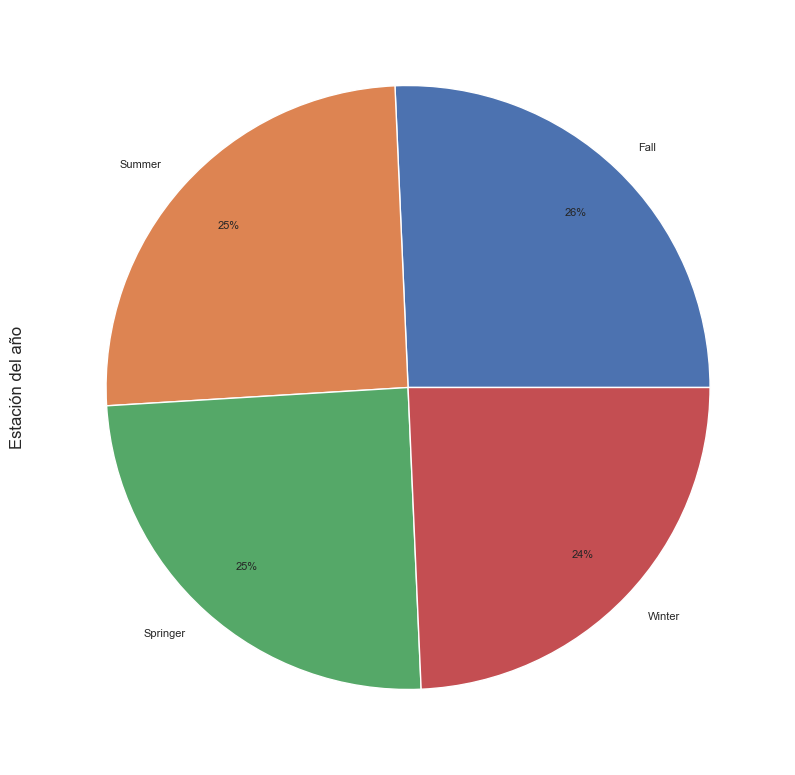

In [28]:
#Distribución de las estaciones del año
fig = plt.figure(figsize=(10,10), dpi=100)
df2['Season'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=8, ylabel='Estación del año',pctdistance=0.8)

Se realiza un gráfico de torta con la distribución de las estaciones durante el año, esto como un indicativo de la consistencia de los datos. Se espera que dichas estaciones tengan una duración similar de año a año.

#### Distribución del clima

<AxesSubplot:ylabel='Descripción del tiempo'>

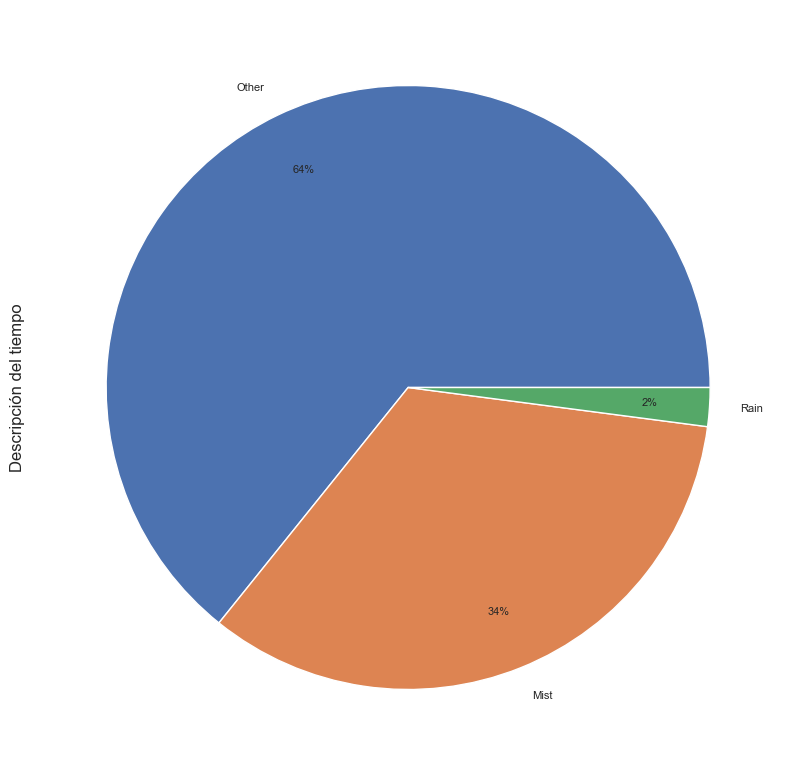

In [29]:
#Distribución de las estaciones del año
fig = plt.figure(figsize=(10,10), dpi=100)
df2['Weather'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=8, ylabel='Descripción del tiempo',pctdistance=0.8)

Se realiza una descripción de la distribución del clima, cómo se observa el tiempo con neblina es muy alto y esto podría disminuir significativamente el número de usuarios. Por otro lado, la lluvia representa apenas el 2% de la condición climática en general.

#### Comportamiento de las condiciones climáticas

<b> Temperatura promedio en cada mes para los dos años

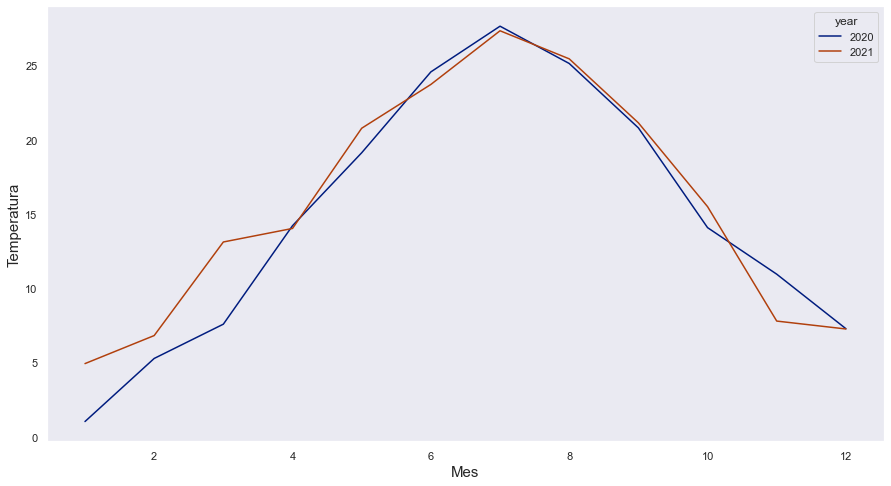

In [30]:
#Se realiza un gráfico para observar el comportamiento de la temperatura promedio por mes.
sns.set(rc = {'figure.figsize':(15,8)})
p=sns.lineplot(x='month', y='Temp', data=df2, hue='year',palette="dark", ci=None)
p.set_xlabel("Mes", fontsize = 15)
p.set_ylabel("Temperatura", fontsize = 15)
plt.grid()
plt.show()

<b> Sensación térmica promedio en cada mes para los dos años

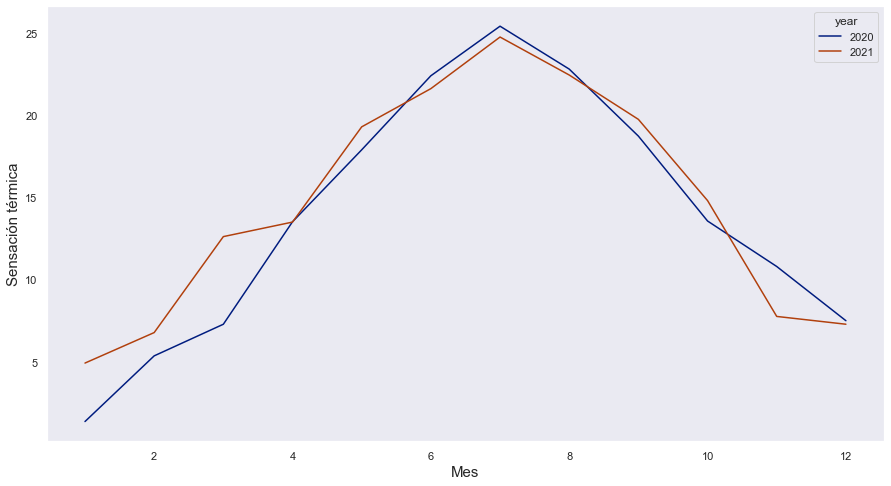

In [31]:
#Se realiza un gráfico para observar el comportamiento del promedio de la sensación térmica durante los dos años.
sns.set(rc = {'figure.figsize':(15,8)})
p1=sns.lineplot(x='month', y='Feel_Temp', data=df2, hue='year',palette="dark", ci=None)
p1.set_xlabel("Mes", fontsize = 15)
p1.set_ylabel("Sensación térmica", fontsize = 15)
plt.grid()
plt.show()

Se observan un aumento de temperatura y sensación terminca entre el mes 6 y 8, es importante tener esto en cuenta y observar que influencia tiene esto en el número de usuarios.

<b> Humedad promedio de cada mes durante los dos años

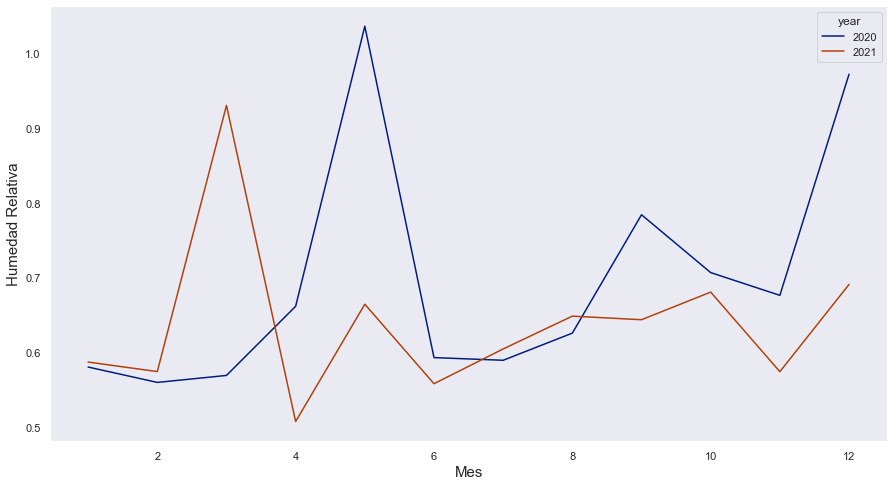

In [32]:
#Se realiza un gráfico para observar el comportamiento del promedio de la humedad durante los dos años.
sns.set(rc = {'figure.figsize':(15,8)})
p3=sns.lineplot(x='month', y='Hum', data=df2, hue='year',palette="dark", ci=None)
p3.set_xlabel("Mes", fontsize = 15)
p3.set_ylabel("Humedad Relativa", fontsize = 15)
plt.grid()
plt.show()

No hay un patrón tan definido en el comportamiento de la humedad, por ejemplo, para el año 2020 se observa que el mes 5 es uno de los más húmedos, mientras que para el año 2021 es el mes 3. 

<b> Velocidad del viento por cada mes durante los dos años

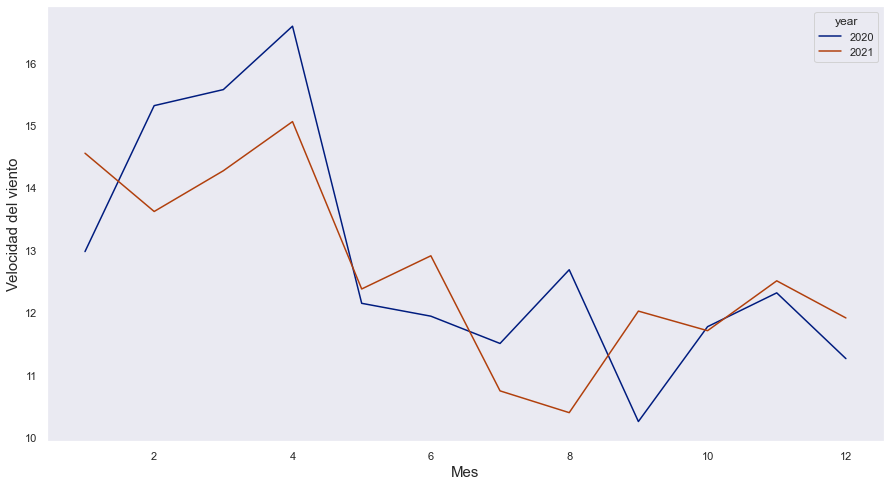

In [33]:
#Se realiza un gráfico para observar el comportamiento del promedio de la velocidad del viento durante los dos años.
sns.set(rc = {'figure.figsize':(15,8)})
p4=sns.lineplot(x='month', y='Wind', data=df2, hue='year',palette="dark", ci=None)
p4.set_xlabel("Mes", fontsize = 15)
p4.set_ylabel("Velocidad del viento", fontsize = 15)
plt.grid()
plt.show()

<b> Cantidad de usuarios (regitrados y casuales) por mes durante los dos años

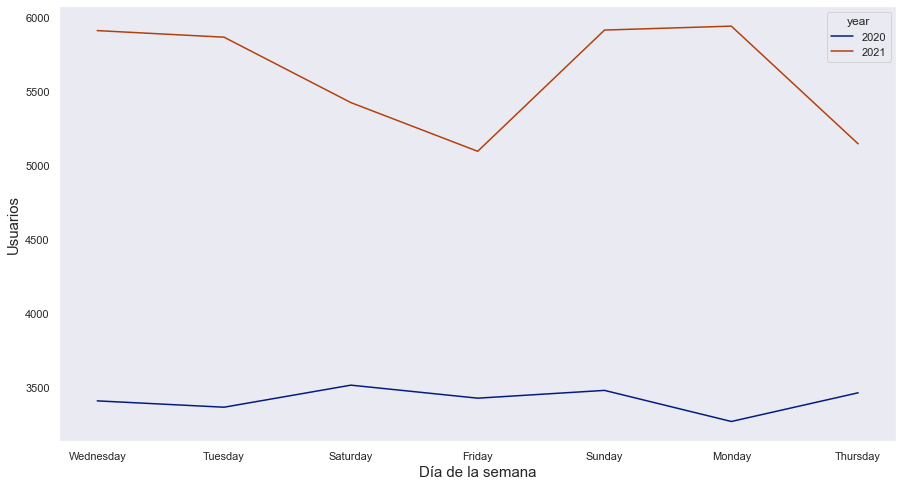

In [34]:
#Se realiza un gráfico para observar el comportamiento del promedio de la cantidad de usarios (entre los registrados y los casuales)
sns.set(rc = {'figure.figsize':(15,8)})
p5=sns.lineplot(x='dayofweek', y='cnt', data=df2, hue='year',palette="dark", ci=None)
p5.set_xlabel("Día de la semana", fontsize = 15)
p5.set_ylabel("Usuarios", fontsize = 15)
plt.grid()
plt.show()

Esta variable es de vital importancia evaluarla debido a la condición mundial que se vivió durante el año 2020. Se observa que para el año 2020 hay una cantidad significativamente menor y esto podría impedir un ajuste adecuado del modelo para futuras predicciones.

##### Visualización general de los datos

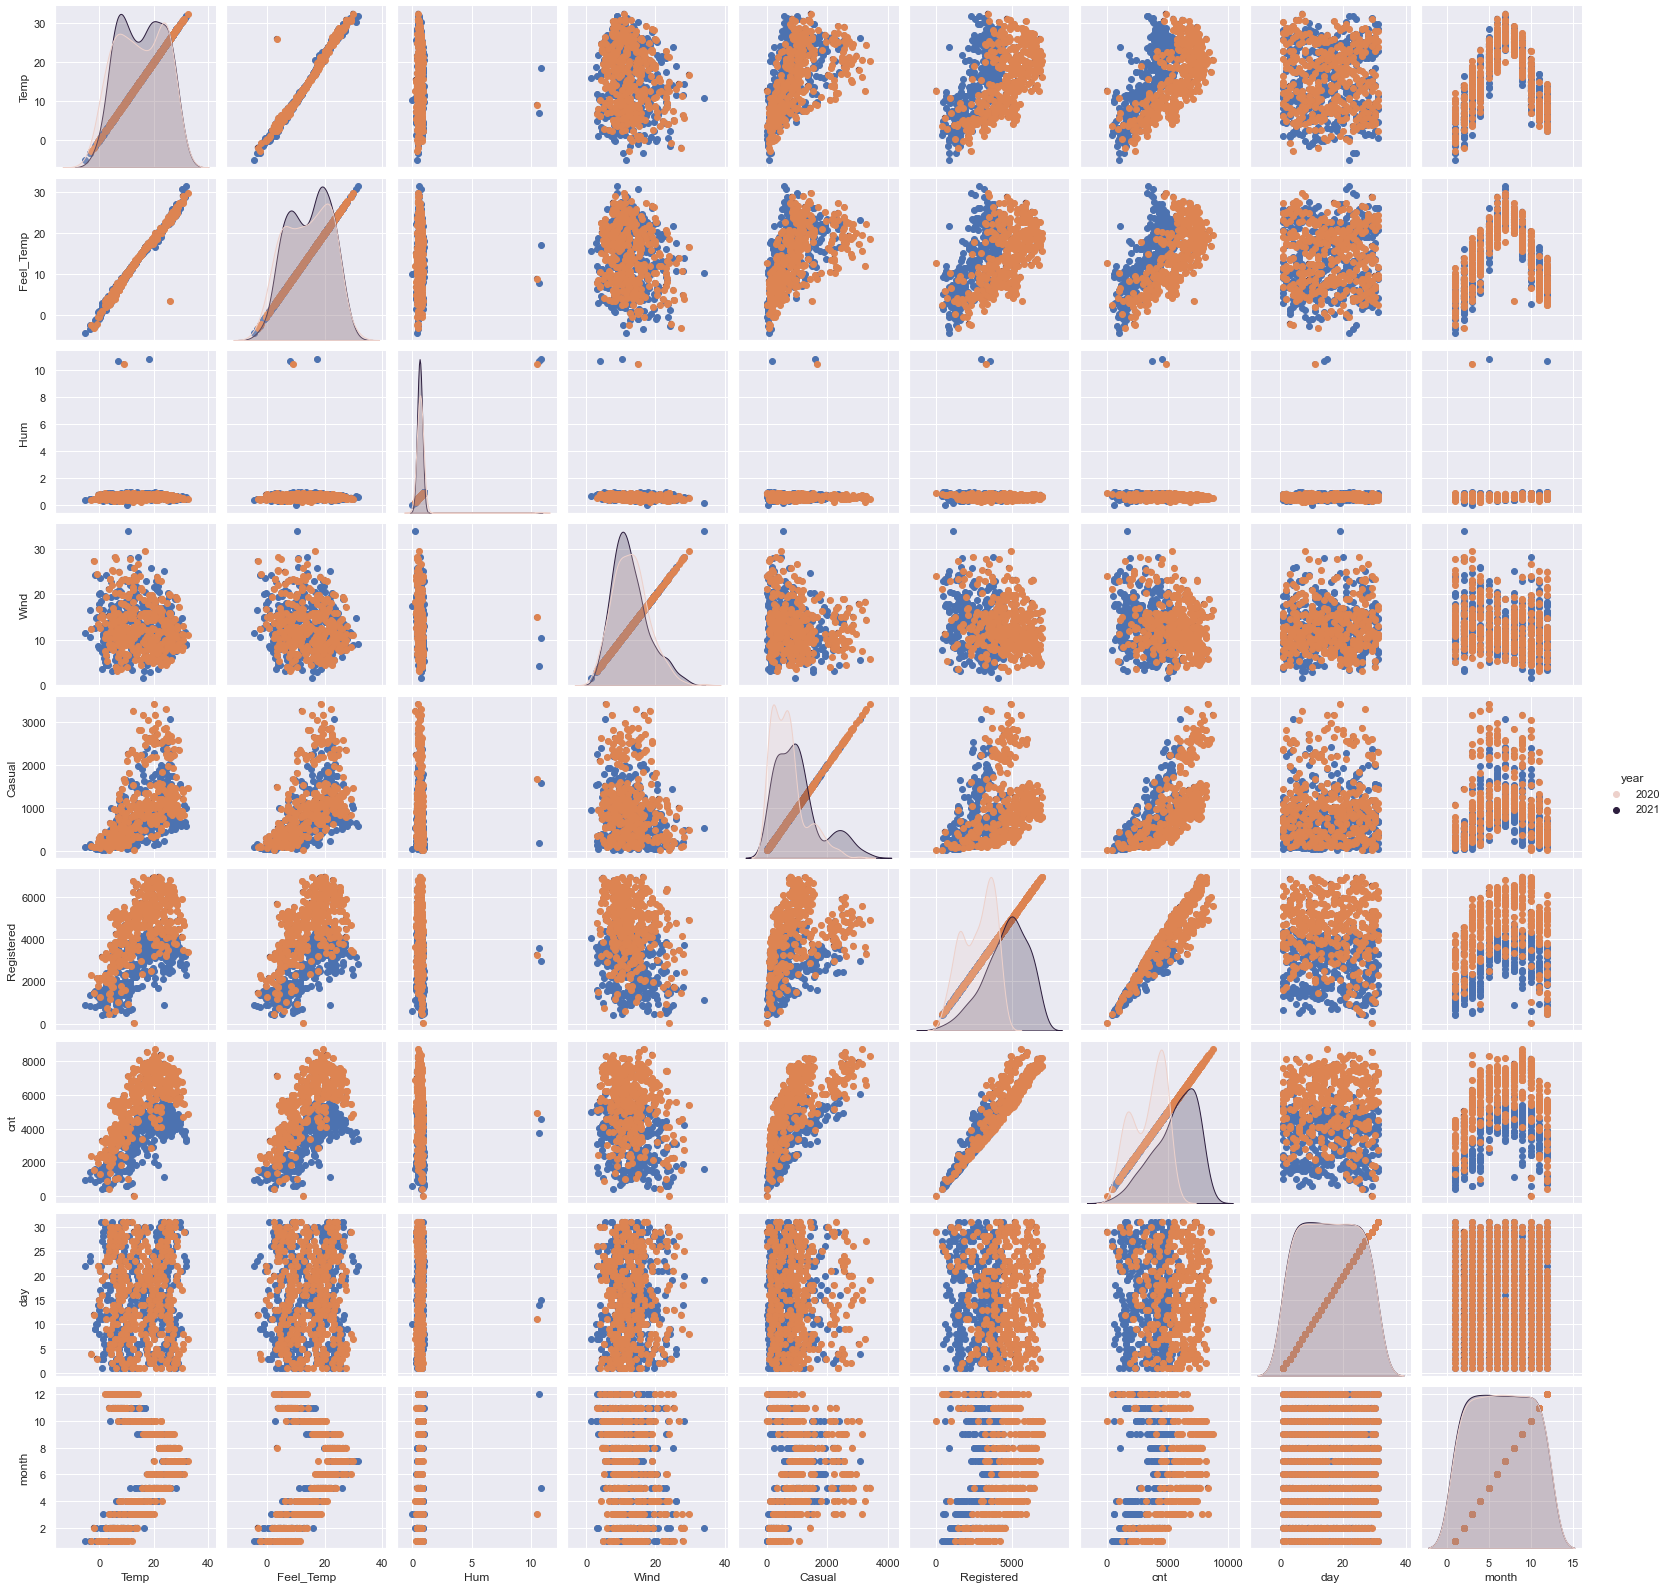

In [35]:
# Se realiza una exploracion general de los datos 
g=sns.pairplot(df2, hue = "year")
g.map(plt.scatter)

En esta visualización general de los datos se observan lo siguiente:</p>
-La temperatura y sensación térmica podrían tener una alta correlación con la cantidad de usuarios.</p>
-Para los meses 6 y 7 se observa un incremento en la cantidad de usuarios que podría estar relacionada con el aumento de la temperatura y la sensación térmica.</p>
-El resto de las variables es necesario evaluaras con una matriz de correlación. Se observa una alta correlación con los usuarios registrados y casuales ya que son dependientes.

<b> Se realiza la matriz de correlación 

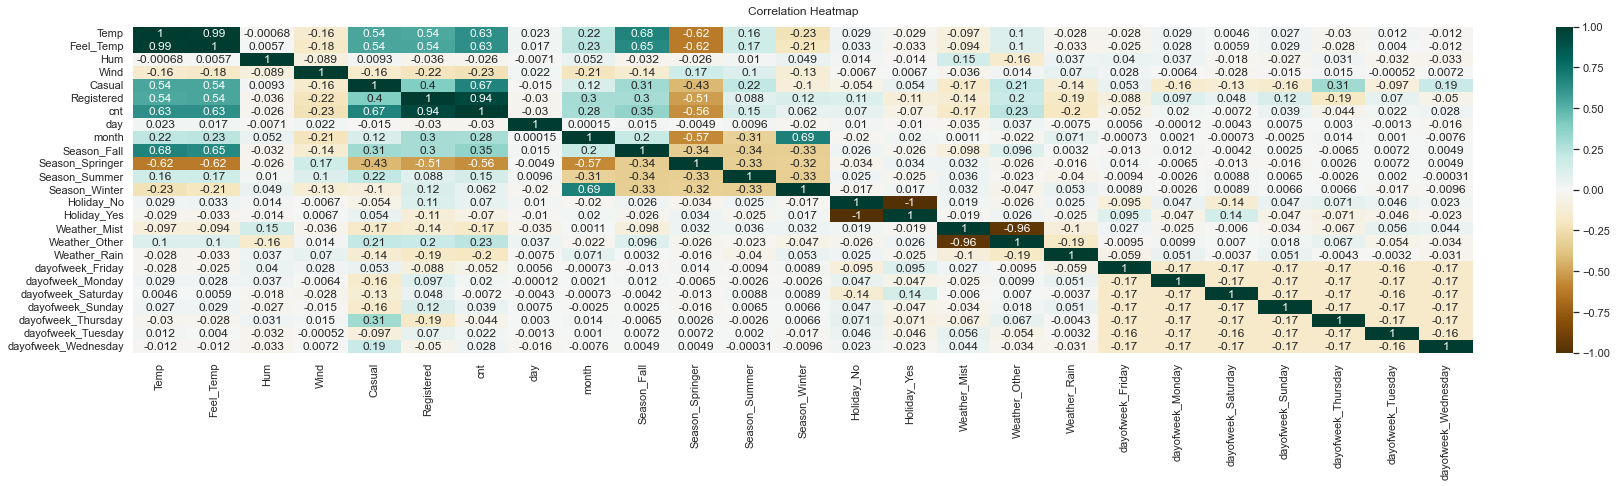

In [36]:
#Se cambian los datos categoricos del dataframe para poder realizar las respectivas regresiones
df3 = pd.get_dummies(df2,columns = ['Season','Holiday','Weather','dayofweek'])
df3=df3.drop('year',axis=1)
#Mapa de calor
# Increase the size of the heatmap.
plt.figure(figsize=(30, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df3.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Se observa que para la variable ‘cnt’ que representa la cantidad de usuarios registrados y casuales, las variables que tienen mayor correlación positiva son: </p>
•	Temperatura</p>
•	Sensación térmica</p>
•	La estación otoño</p>
•	El mes del año</p>
•	Las condiciones climáticas denominadas otros</p>
Las variables que tienen mayor correlación negativa son: </p>
•	La estación del año sea la primavera</p>
•	La velocidad del viento</p>
•	Que el día este nublado</p>

##### Entrenamiento del modelo de regresión líneal

In [37]:
df4=df3.drop(['Casual','Registered','Date'],axis=1)

<b> Separación de variables y obtención de datos de entrenamiento y prueba

In [45]:
#Separación de variables de entrada
x_i=df4.drop(columns = ['cnt'])
#normalización de las variables de entrada
scaler.fit(x_i)
scaled=scaler.transform(x_i)
x= pd.DataFrame(scaled, columns=x_i.columns)
y=df4.cnt

<b> Modelo de regresión lineal

In [46]:
#División de los datos de entrenamiento y de prueba 
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.2,random_state=14)
#modelo de regresión lineal
dflr=LinearRegression()
dflr.fit(x_train,y_train)
y_pred = dflr.predict(x_test)
#mean absolute Error
MAE=abs(y_pred-y_test).sum()/len(y_pred)
print('Mean absolute Error')
print(MAE)
#Mean square error
MSE=((y_pred-y_test)**2).sum()/len(y_pred)
print('Mean square error')
print(MSE)
#Mean absolute percentage error
MAPE=abs((y_test-y_pred)/y_test).sum()/len(y_test)
print('Mean absolute percentage error')
print(MAPE)
#Mean percentage error
MPE=((y_test-y_pred)/y_test).sum()/len(y_test)
print('Mean percentage error')
print(MPE)

Mean absolute Error
1144.2309287814282
Mean square error
1736738.3574667827
Mean absolute percentage error
0.339755332420155
Mean percentage error
-0.15254224147913126


<b> Modelo de regresión polinómica de grado 2

In [40]:
#polinomio grado dos
poly_reg=PolynomialFeatures(degree=2)
X_poly=poly_reg.fit_transform(x_train)
poly_reg.fit(X_poly,y_train)
lin_reg2=LinearRegression()
lin_reg2.fit(X_poly,y_train)
y_pred2f=lin_reg2.predict(poly_reg.fit_transform(x_test))
#Error de los datos de prueba 
#mean absolute Error
MAE2=abs(y_pred2f-y_test).sum()/len(y_test)
print('Mean absolute Error')
print(MAE2)
#Mean square error
MSE2=((y_pred2f-y_test)**2).sum()/len(y_test)
print('Mean square error')
print(MSE2)
#Mean absolute percentage error
MAPE2=abs((y_test-y_pred2f)/y_test).sum()/len(y_test)
print('Mean absolute percentage error')
print(MAPE2)
#Mean percentage error
MPE2=((y_test-y_pred2f)/y_test).sum()/len(y_test)
print('Mean percentage error')
print(MPE2)

Mean absolute Error
92605696358989.34
Mean square error
1.0169510398711086e+30
Mean absolute percentage error
63523712029.942955
Mean percentage error
27298943386.537346


<b> Modelo de regresión polinómica de grado 3

In [41]:
poly_reg=PolynomialFeatures(degree=3)
X_poly=poly_reg.fit_transform(x_train)
poly_reg.fit(X_poly,y_train)
lin_reg3=LinearRegression()
lin_reg3.fit(X_poly,y_train)
y_pred3f=lin_reg3.predict(poly_reg.fit_transform(x_test))
#Error de los datos de prueba 
#mean absolute Error
MAE3=abs(y_pred3f-y_test).sum()/len(y_test)
print('Mean absolute Error')
print(MAE3)
#Mean square error
MSE3=((y_pred3f-y_test)**2).sum()/len(y_test)
print('Mean square error')
print(MSE3)
#Mean absolute percentage error
MAPE3=abs((y_test-y_pred3f)/y_test).sum()/len(y_test)
print('Mean absolute percentage error')
print(MAPE3)
#Mean percentage error
MPE3=((y_test-y_pred3f)/y_test).sum()/len(y_test)
print('Mean percentage error')
print(MPE3)

Mean absolute Error
27214.309711401143
Mean square error
5679399826.415354
Mean absolute percentage error
28.348875561960764
Mean percentage error
-8.172585954984788


<b> Modelo de ajuste de Ridge con alpha igual a 1

In [42]:
ridge1=Ridge(alpha=1)
ridge1.fit(x_train, y_train)
ridge1
y_pred1r=ridge1.predict(x_test)
#Error de los datos de prueba 
#mean absolute Error
MAER1=abs(y_pred1r-y_test).sum()/len(y_test)
print('Mean absolute Error')
print(MAER1)
#Mean square error
MSER1=((y_pred1r-y_test)**2).sum()/len(y_test)
print('Mean square error')
print(MSER1)
#Mean absolute percentage error
MAPER1=abs((y_test-y_pred1r)/y_test).sum()/len(y_test)
print('Mean absolute percentage error')
print(MAPER1)
#Mean percentage error
MPER1=((y_test-y_pred1r)/y_test).sum()/len(y_test)
print('Mean percentage error')
print(MPER1)

Mean absolute Error
1197.390400848958
Mean square error
1918202.4815048554
Mean absolute percentage error
1.7778745885150053
Mean percentage error
-1.5881730522604327


<b> Modelo de ajuste de Ridge con alpha igual a 5

In [43]:
ridge5=Ridge(alpha=5)
ridge5.fit(x_train, y_train)
ridge5
y_pred5r=ridge5.predict(x_test)
#Error de los datos de prueba 
#mean absolute Error
MAER2=abs(y_pred5r-y_test).sum()/len(y_test)
print('Mean absolute Error')
print(MAER2)
#Mean square error
MSER2=((y_pred5r-y_test)**2).sum()/len(y_test)
print('Mean square error')
print(MSER2)
#Mean absolute percentage error
MAPER2=abs((y_test-y_pred5r)/y_test).sum()/len(y_test)
print('Mean absolute percentage error')
print(MAPER2)
#Mean percentage error
MPER2=((y_test-y_pred5r)/y_test).sum()/len(y_test)
print('Mean percentage error')
print(MPER2)

Mean absolute Error
1195.556481911204
Mean square error
1916069.1875770946
Mean absolute percentage error
1.792389716127259
Mean percentage error
-1.6110782791137204


<b> Resumen de errores obtenidos para cada modelo

In [44]:
Final = pd.DataFrame({'MAE' : [MAE, MAE2, MAE3, MAER1,MAER2],'MSE' : [MSE, MSE2, MSE3, MSER1,MSER2],'MAPE' : [MAPER2, MAPE2, MAPE3, MAPER1,MAPER2],'MPE' : [MPE, MPE2, MPE3, MPER1,MPER2]},index=('R.Lineal', 'Poli.G2', 'Poli.G3', 'Ridge_alpha=1','Ridge_alpha=5'))
Final

,MAE,MSE,MAPE,MPE
R.Lineal,1.197134e+03,1.917336e+06,1.792390e+00,-1.570614e+00
Poli.G2,9.260570e+13,1.016951e+30,6.352371e+10,2.729894e+10
Poli.G3,2.721431e+04,5.679400e+09,2.834888e+01,-8.172586e+00
Ridge_alpha=1,1.197390e+03,1.918202e+06,1.777875e+00,-1.588173e+00
Ridge_alpha=5,1.195556e+03,1.916069e+06,1.792390e+00,-1.611078e+00


Se observa que el modelo que mejor se ajusta es el de Ridge con un valor de Alpha igual a 1, se realiza a continuación una predicción con todos los datos y se compara el comportamiento con respecto a la temperatura para el modelo de regresión lineal y el Ridge.

<b> Comportamiento del modelo

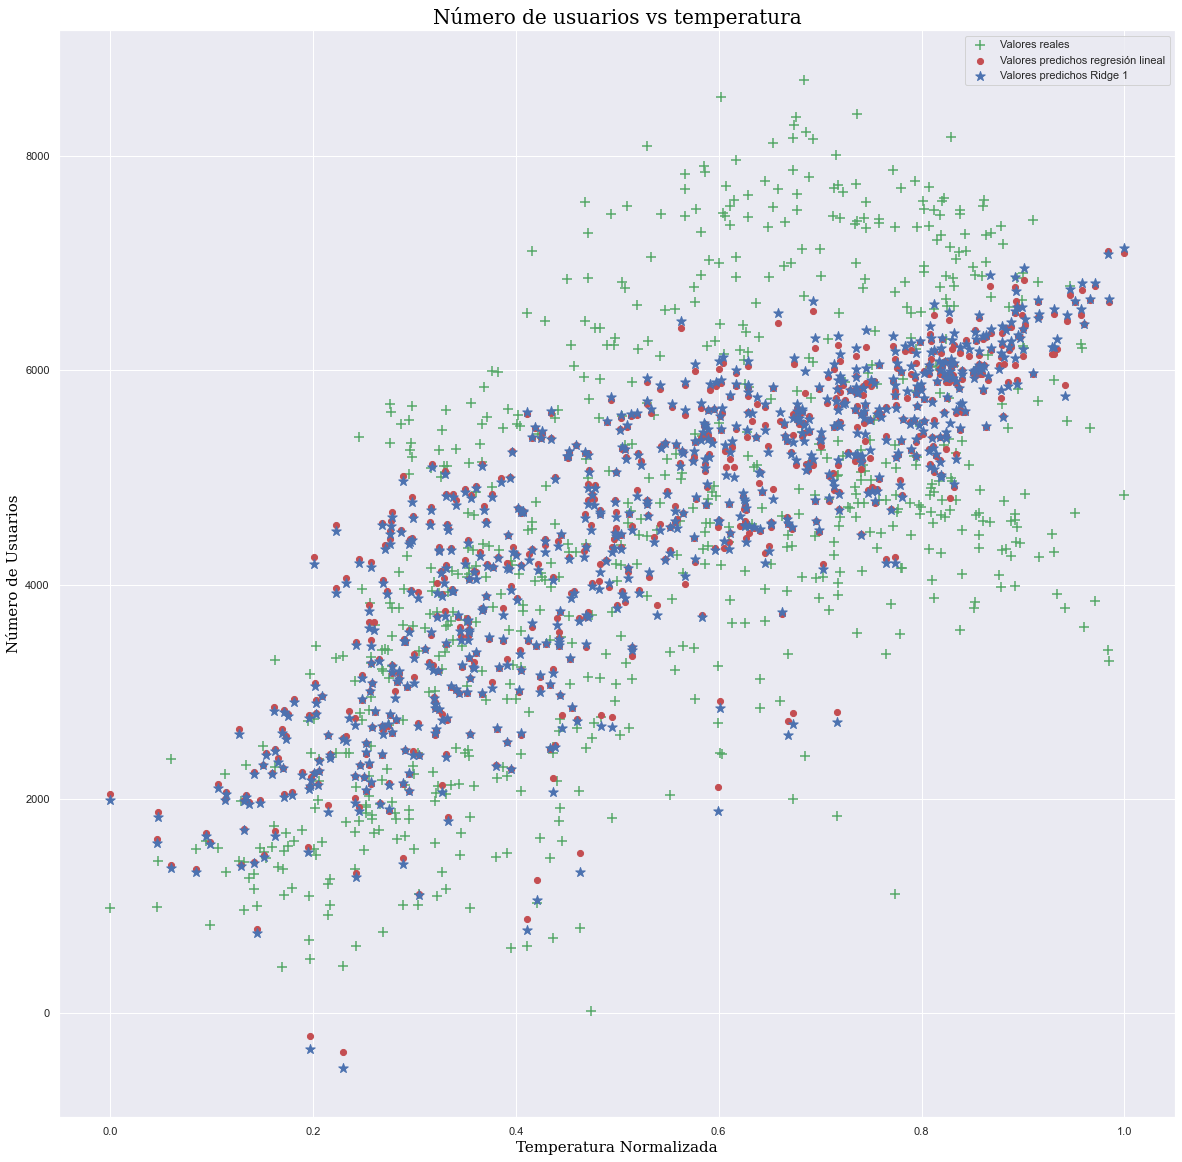

In [186]:
y_finalL=dflr.predict(x)
#y_finalP2=lin_reg2.predict(poly_reg.fit_transform(x))
y_finalP3=lin_reg3.predict(poly_reg.fit_transform(x))
y_finalR1=ridge1.predict(x)
y_finalR5=ridge5.predict(x)
font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'black','size':15}
# multiple lines with legend
plt.figure(figsize=(20,20))
plt.title("Número de usuarios vs temperatura",fontdict = font1)
plt.xlabel("Temperatura Normalizada",fontdict = font2)
plt.ylabel("Número de Usuarios",fontdict = font2)
plt.scatter(x.Temp,y,marker='+', color='g', label= 'Valores reales',s=100)
plt.scatter(x.Temp,y_finalR1,marker='.', color='r', label= 'Valores predichos regresión lineal',s=150)
plt.scatter(x.Temp,y_finalL,marker='*', color='b', label= 'Valores predichos Ridge 1',s=100)
plt.legend();

Se observa que el modelo se ajusta, pero hay gran cantidad de valores por del esperado. El error absoluto es muy alto con respecto a la media.

<b> Mejorar el modelo </p>
Para mejorar el modelo se recomienda actualizar los datos con respecto al año 2022 y realizar un entrenamiento con dichos valores, ya que la cantidad de usuarios para el año 2022 es siginificativamente menor y estaría llevando al modelo a predecir valores mas bajos de los esperados, esto podría ser debido a las condiciones mundiales con respecto al covid 19.

Se realiza una prueba de ajuste únicamente con los datos del año 2021

In [74]:
df5 = pd.get_dummies(df2,columns = ['Season','Holiday','Weather','dayofweek'])
df5=df5[df5['year'] >= 2021]
df5=df5.drop(['Casual','Registered','Date','year'],axis=1)
df5
#Separación de variables de entrada
x_i=df5.drop(columns = ['cnt'])
#normalización de las variables de entrada
scaler.fit(x_i)
scaled=scaler.transform(x_i)
x= pd.DataFrame(scaled, columns=x_i.columns)
y=df5.cnt
#División de los datos de entrenamiento y de prueba 
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.4,random_state=10)
ridge1=Ridge(alpha=1)
ridge1.fit(x_train, y_train)
ridge1
y_pred1r=ridge1.predict(x_test)
#Error de los datos de prueba 
#mean absolute Error
MAER1=abs(y_pred1r-y_test).sum()/len(y_test)
print('Mean absolute Error')
print(MAER1)
#Mean square error
MSER1=((y_pred1r-y_test)**2).sum()/len(y_test)
print('Mean square error')
print(MSER1)
#Mean absolute percentage error
MAPER1=abs((y_test-y_pred1r)/y_test).sum()/len(y_test)
print('Mean absolute percentage error')
print(MAPER1)
#Mean percentage error
MPER1=((y_test-y_pred1r)/y_test).sum()/len(y_test)
print('Mean percentage error')
print(MPER1)

Mean absolute Error
704.9118464665371
Mean square error
904591.4994645433
Mean absolute percentage error
0.15705714564578582
Mean percentage error
-0.061592058520380195


Se observa que al no tener en cuenta los datos para el año de 2020, el modelo se ajusta mas favorablemente. En el modelo anterior se pudo tomar como una variable el año, pero esto para el año de 2023 en adelante podría sobre dimensionar significativamente la predicción.